You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.
Using 20200408 Chou's data, unit2.

# Functions

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.stats import loglaplace,chi2

from labellines import labelLine, labelLines
import os
%matplotlib inline

In [31]:
def Histo3D2Dict(P):
    PDF = dict()
    for i in range(np.size(P, 0)):
        for j in range(np.size(P, 1)):
            for k in range(np.size(P, 2)):
                PDF[(k,i,j)] = float(P[i,j,k])
    return PDF

In [32]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [33]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [34]:
def Get_StimulusnResponse(ExporSim, conPar, par_list, IndParValue=1, channelnumber = 39):
    rstate_list = []
    if ExporSim=='Exp':
        x_list = []
        T_list = []
        if conPar=='Gramma':
            for G in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
            dt = 1/60
        elif conPar=='Fc':
            for Fc in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
                if Fc == 0:
                    annots = loadmat(exp_folder+'\\20200408_OU_original_tau=0p5_sort_unit2')
                else:
                    annots = loadmat(exp_folder+'\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2')
                dt = 0.01
                sampling_rate = 20000
                TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
                TimeStamps = TimeStamps.astype(int)
                x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
                x = x[::int(sampling_rate*dt)]
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T=np.arange(len(x))*dt
                rstate, _ = np.histogram(annots['Spikes'][0][channelnumber-1]-TimeStamps[0], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
    else:    ##'Sim':
        if conPar=='Tau':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= 0.1
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            cutoffFreq = IndParValue
            for tau in par_list:
                for i in range(len(T)-1):
                    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
                # filtering for OUSmoothed
                LPOU_list = []
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        elif conPar=='Fc':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= IndParValue
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            for i in range(len(T)-1):
                OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
            # filtering for OUSmoothed
            LPOU_list = []
            for cutoffFreq in par_list:
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        T_list = [T]*len(par_list)
    return x_list, T_list, dt, rstate_list


In [35]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

In [36]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian(xx,sigma_dict['C'])
    KH = Gaussian(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

In [37]:
def Gaussian(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [38]:
# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# Main

Loading Exp.mat for position series

In [39]:
loadfiles = np.load('4PID_paper\\lambda vs. PI\\PeakHeightnTime vs Fc.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]

loadfiles = np.load('4PID_paper\\beta vs. PI\\PeakHeightnTime vs Fc.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()['b_'+k] = loadfiles[k][()]

x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Fc', Fc_list, _, 1)
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3))

In [11]:
t_cor_list

[0.523, 0.421, 0.394, 0.383]

In [12]:
model_Uvox_ratio_list_list = []
b_model_Uvox_ratio_list_list = []
Lambda_list = np.arange(0.3,0.85,0.05)
beta_list = (1-Lambda_list)/Lambda_list
for Lambda in Lambda_list:
    model_Uvox_ratio_list = []
    b_model_Uvox_ratio_list = []
    for i in range(len(Fc_list)):
        Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
        model_Uvox_ratio = np.interp(Lambda, Lambdas, Uvox_ratio_table)
        model_Uvox_ratio_list.append(model_Uvox_ratio.copy())
        
        b_Uvox_ratio_table = ndimage.gaussian_filter1d(b_Uv_peakH_list[i]/b_Ux_peakH_list[i], sigma=1, mode='reflect')
        b_model_Uvox_ratio = np.interp(Lambda, b_Lambdas, b_Uvox_ratio_table)
        b_model_Uvox_ratio_list.append(b_model_Uvox_ratio.copy())
    model_Uvox_ratio_list_list.append(model_Uvox_ratio_list.copy())
    b_model_Uvox_ratio_list_list.append(b_model_Uvox_ratio_list.copy())
model_Uvox_ratio_list_list = np.array(model_Uvox_ratio_list_list)
b_model_Uvox_ratio_list_list = np.array(b_model_Uvox_ratio_list_list)




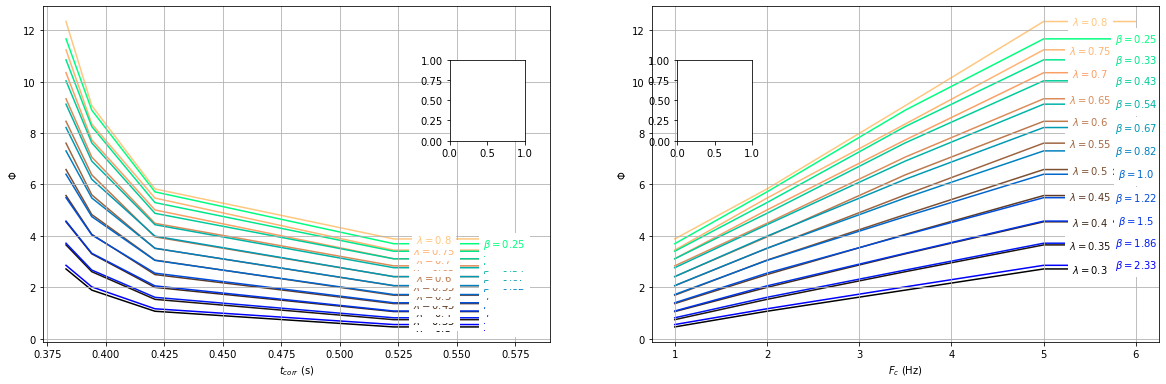

In [52]:
THEfig, (THEax1, THEax2) = plt.subplots(1,2)
THEax1.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(model_Uvox_ratio_list_list)))))
THEax2.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(model_Uvox_ratio_list_list)))))
axin2 = THEax2.inset_axes([0.05, 0.60, 0.12*(np.sqrt(5)-1), 0.24])
axin1 = THEax1.inset_axes([0.95-0.12*(np.sqrt(5)-1), 0.60, 0.12*(np.sqrt(5)-1), 0.24])
# ax.plot(Fc_list, model_Uvox_ratio_list_list.T, zorder=1)
pt_cor_list = np.append(np.flip(t_cor_list), 0.58)
pFc_list = np.append(Fc_list, 6.*2)
for i in range(len(model_Uvox_ratio_list_list)):
    pmodel_Uvox_ratio = np.append((model_Uvox_ratio_list_list[i]), model_Uvox_ratio_list_list[i][-1])
    THEax2.plot(pFc_list/2, pmodel_Uvox_ratio, zorder=1, label=r'$\lambda=$'+str(np.round(Lambda_list[i],2)) )
    pmodel_Uvox_ratio = np.append(np.flip(model_Uvox_ratio_list_list[i]), model_Uvox_ratio_list_list[i][0])
    THEax1.plot(pt_cor_list, pmodel_Uvox_ratio, zorder=1, label=r'$\lambda=$'+str(np.round(Lambda_list[i],2)) )

THEax1.set_prop_cycle(plt.cycler('color', plt.cm.winter(np.linspace(0, 1, len(model_Uvox_ratio_list_list)))))
THEax2.set_prop_cycle(plt.cycler('color', plt.cm.winter(np.linspace(0, 1, len(model_Uvox_ratio_list_list)))))
for i in range(len(model_Uvox_ratio_list_list)):
    pmodel_Uvox_ratio = np.append((b_model_Uvox_ratio_list_list[i]), b_model_Uvox_ratio_list_list[i][-1])
    THEax2.plot(pFc_list/2, pmodel_Uvox_ratio, zorder=1, label=r'$\beta=$'+str(np.round(beta_list[i],2)) )
    pmodel_Uvox_ratio = np.append(np.flip(b_model_Uvox_ratio_list_list[i]), b_model_Uvox_ratio_list_list[i][0])
    THEax1.plot(pt_cor_list, pmodel_Uvox_ratio, zorder=1, label=r'$\beta=$'+str(np.round(beta_list[i],2)) )
    
THEax1.set_xlabel(r'$t_{corr}$ (s)')
THEax2.set_xlabel(r'$F_{c}$ (Hz)')
THEax1.set_ylabel(r'$\Phi$')
THEax2.set_ylabel(r'$\Phi$')
THEax1.grid()
THEax2.grid()
txvals = len(model_Uvox_ratio_list_list)*[0.54]
txvals.extend(len(model_Uvox_ratio_list_list)*[0.57])
fxvals = len(model_Uvox_ratio_list_list)*[5.5]
fxvals.extend(len(model_Uvox_ratio_list_list)*[6.])
labelLines(THEax1.get_lines(),zorder=2.5, xvals=txvals)
labelLines(THEax2.get_lines(),zorder=2.5, xvals=fxvals)
a = 5
THEfig.set_size_inches(a*4, a*(np.sqrt(5)-1))
THEfig2 = THEfig

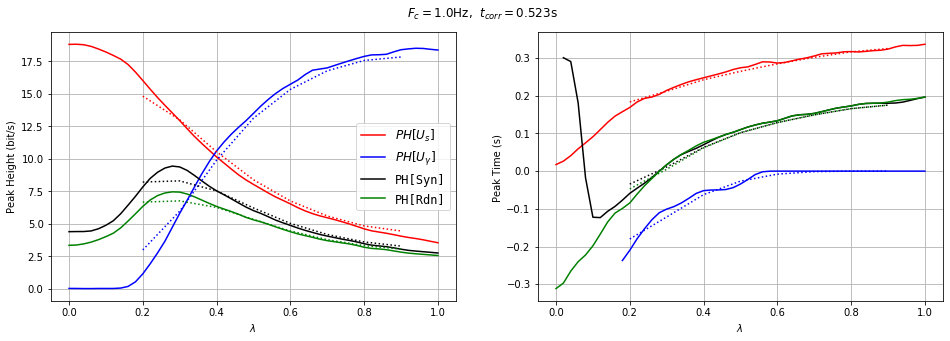

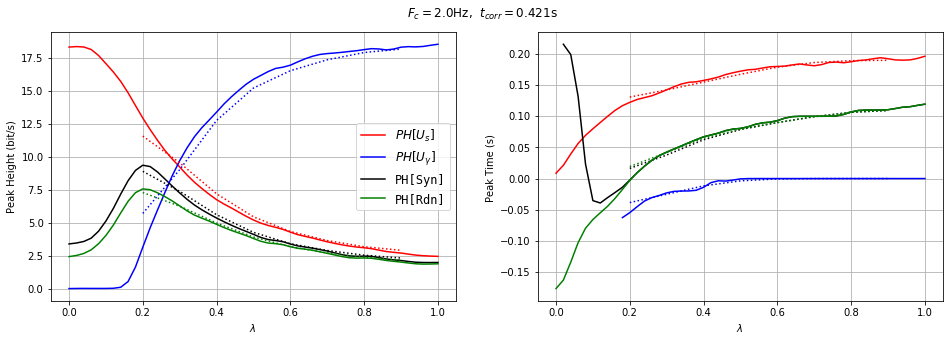

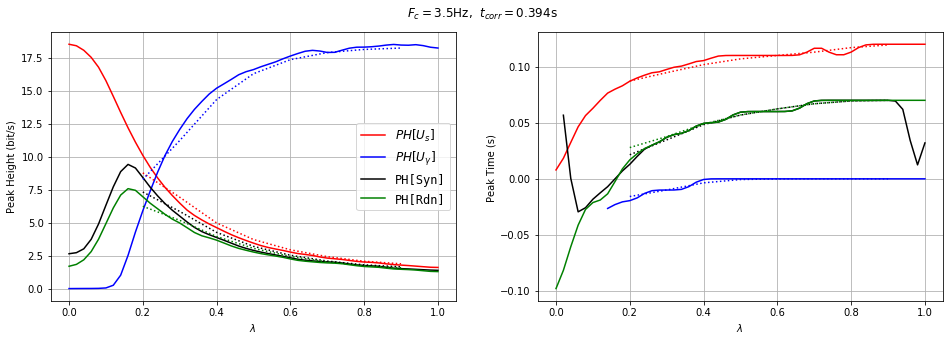

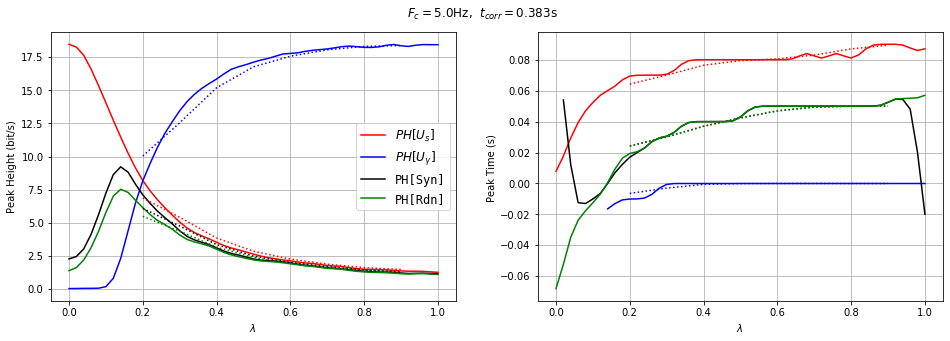

In [14]:
for i in range(len(Fc_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    fig.set_size_inches(16, 4*(np.sqrt(5)-1))
    fig.suptitle(r'$F_c = $'+ str(Fc_list[i]/2)+'Hz,  '+r'$t_{corr}=$'+str(round(t_cor_list[i],3))+'s',y =0.95)
    ax2.plot(Lambdas,ndimage.gaussian_filter1d(Ux_peakH_list[i], sigma=1, mode='reflect'), 'r-')
    ax2.plot(Lambdas,ndimage.gaussian_filter1d(Uv_peakH_list[i], sigma=1, mode='reflect'), 'b-')
    ax2.plot(Lambdas,ndimage.gaussian_filter1d(Syn_peakH_list[i], sigma=1, mode='reflect'), 'k-')
    ax2.plot(Lambdas,ndimage.gaussian_filter1d(Rdn_peakH_list[i], sigma=1, mode='reflect'), 'g-')
    
    ax2.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Ux_peakH_list[i], sigma=1, mode='reflect'), 'r:')
    ax2.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Uv_peakH_list[i], sigma=1, mode='reflect'), 'b:')
    ax2.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Syn_peakH_list[i], sigma=1, mode='reflect'), 'k:')
    ax2.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Rdn_peakH_list[i], sigma=1, mode='reflect'), 'g:')
    
    ax2.set_xlabel(r'$\lambda $ ')
    ax2.set_ylabel(r'Peak Height (bit/s)')
    ax2.grid(True)
    ax2.legend((r'$PH[U_s]$', r'$PH[U_{\gamma}]$', 'PH[Syn]', 'PH[Rdn]'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    
    
    ax3.plot(Lambdas,ndimage.gaussian_filter1d(Ux_peaktime_list[i], sigma=1, mode='reflect'), 'r-')
    ax3.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Ux_peaktime_list[i], sigma=1, mode='reflect'), 'r:')
    usefullI = np.where(Uv_peakH_list[i]>=0.08)
    ax3.plot(Lambdas[usefullI],ndimage.gaussian_filter1d(Uv_peaktime_list[i][usefullI], sigma=1, mode='reflect'), 'b-')
    ax3.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Uv_peaktime_list[i], sigma=1, mode='reflect'), 'b:')
    usefullI = np.where(Syn_peakH_list[i]>=8)
    usefullI =np.arange(1,51)
    ax3.plot(Lambdas[usefullI],ndimage.gaussian_filter1d(Syn_peaktime_list[i][usefullI], sigma=1, mode='reflect'), 'k-')
    ax3.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Syn_peaktime_list[i], sigma=1, mode='reflect'), 'k:')
    usefullI = np.where(Rdn_peakH_list[i]>=1)
    usefullI =np.arange(0,51)
    ax3.plot(Lambdas[usefullI],ndimage.gaussian_filter1d(Rdn_peaktime_list[i][usefullI], sigma=1, mode='reflect'), 'g-')
    ax3.plot(b_Lambdas,ndimage.gaussian_filter1d(b_Rdn_peaktime_list[i], sigma=1, mode='reflect'), 'g:')
    ax3.set_xlabel(r'$\lambda$ ')
    ax3.set_ylabel('Peak Time (s) ')
#     ax3.legend( (r'$PT[U_s]$', r'$PT[U_{\gamma}]$', 'PT[Syn]', 'PT[Rdn]'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax3.grid(True)

In [15]:
pcells = [1,20,33,39,40,42,53]
pcell_pos = [[1,7], [3,3], [5,6], [6,8], [6,7], [6,5], [7,2]]
Uvox_ratio_list_cells = []

for pcell in pcells:
    Fc_list = [2,4,7,10]
    x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Fc', Fc_list,_, pcell)
    # x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Gramma', [2.5,4.3,4.5,7.5,20],_, 21)
    # x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Fc', [0.5,1,2,4,8], 1)
    # x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Tau', [1.8,1.4,1,0.6,0.22], 1)

    v_list = []
    for i in range(len(x_list)):
        v = ndimage.gaussian_filter1d(x_list[i].copy(), sigma=5, order=1, mode='reflect') / dt
        v_list.append(v[1:-1].copy())    
        x_list[i] = x_list[i][1:-1]
        T_list[i] = T_list[i][1:-1]
        rstate_list[i] = rstate_list[i][1:-1]

    #assign states
    ystate_list = []
    xstate_list = []
    vstate_list = []

    for i in range(len(x_list)):
        xstate, _= EqualState(x_list[i], 6)
        vstate, _= EqualState(v_list[i], 6)
        xstate_list.append(xstate)
        vstate_list.append(vstate)

    window = [-1,1] # second
    Information_list = [0]*len(x_list)
    Uvox_ratio_list = []
    for i in range(len(x_list)):
        timeshift, Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
        Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
        Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
        Uvox_ratio_list.append(Uvox_ratio)

    
    Uvox_ratio_list_cells.append(Uvox_ratio_list.copy())

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered i

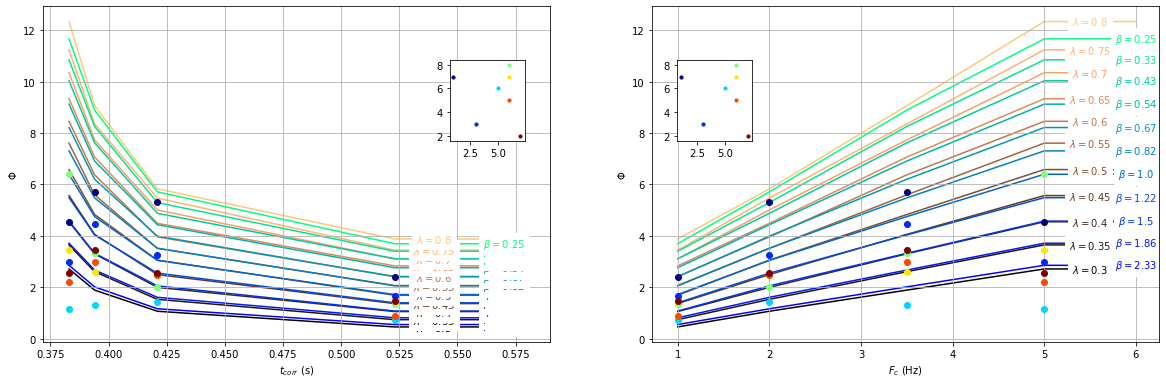

In [53]:
THEax1.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(pcells )))))
THEax2.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(pcells )))))
axin1.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(pcells )))))
axin2.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(pcells )))))
for p in range(len(pcells)):
    THEax2.scatter(np.array(Fc_list)/2, np.array(Uvox_ratio_list_cells[p]), zorder=2 )
    THEax1.scatter(t_cor_list, np.array(Uvox_ratio_list_cells[p]), zorder=2)
    axin1.scatter(pcell_pos[p][0], pcell_pos[p][1], s =[10])
    axin2.scatter(pcell_pos[p][0], pcell_pos[p][1], s =[10])
THEfig